In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define wave speed
c = 1.0

# Neural network
class PINN_Wave(nn.Module):
    def __init__(self, layers):
        super(PINN_Wave, self).__init__()
        self.net = nn.Sequential()
        for i in range(len(layers) - 1):
            self.net.add_module(f"layer_{i}", nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                self.net.add_module(f"tanh_{i}", nn.Tanh())
    
    def forward(self, x):
        return self.net(x)

# Create model
model = PINN_Wave([2, 50, 50, 50, 1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [3]:
# Collocation points
N_f = 10000  # PDE points
N_b = 200    # Boundary points
N_i = 200    # Initial condition points

x_f = torch.rand(N_f, 1, device=device)
t_f = torch.rand(N_f, 1, device=device)
xt_f = torch.cat([x_f, t_f], dim=1)

x_b = torch.cat([torch.zeros(N_b//2, 1), torch.ones(N_b//2, 1)], dim=0).to(device)
t_b = torch.rand(N_b, 1, device=device)
xt_b = torch.cat([x_b, t_b], dim=1)

x_i = torch.rand(N_i, 1, device=device)
t_i = torch.zeros(N_i, 1, device=device)
xt_i = torch.cat([x_i, t_i], dim=1)
u_i = torch.sin(np.pi * x_i).to(device)

# Autograd utilities
def gradients(u, x, order=1):
    for _ in range(order):
        u = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    return u

In [5]:
# Training loop
epochs = 5000
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # Create x and t separately and make sure both require grad
    x_f = xt_f[:, 0:1].clone().detach().requires_grad_(True)
    t_f = xt_f[:, 1:2].clone().detach().requires_grad_(True)
    xt = torch.cat([x_f, t_f], dim=1)

    u_f = model(xt)
    u_t = gradients(u_f, t_f)
    u_tt = gradients(u_t, t_f)
    u_x = gradients(u_f, x_f)
    u_xx = gradients(u_x, x_f)
    
    f_residual = u_tt - c**2 * u_xx
    loss_f = torch.mean(f_residual**2)

    # Boundary loss
    u_b = model(xt_b)
    loss_b = torch.mean(u_b**2)

    # Initial condition loss
    x_i = xt_i[:, 0:1].clone().detach().requires_grad_(True)
    t_i = xt_i[:, 1:2].clone().detach().requires_grad_(True)
    xt_init = torch.cat([x_i, t_i], dim=1)

    u_pred_i = model(xt_init)
    u_t_i = gradients(u_pred_i, t_i)
    loss_ic = torch.mean((u_pred_i - u_i)**2) + torch.mean(u_t_i**2)

    # Total loss
    loss = loss_f + loss_b + loss_ic
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


/home/kchinas/miniconda3/envs/GPU_optimization/lib/python3.10/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 0.503786
Epoch 500, Loss: 0.005328
Epoch 1000, Loss: 0.000601
Epoch 1500, Loss: 0.000261
Epoch 2000, Loss: 0.000172
Epoch 2500, Loss: 0.000152
Epoch 3000, Loss: 0.000124
Epoch 3500, Loss: 0.000757
Epoch 4000, Loss: 0.000112
Epoch 4500, Loss: 0.001441


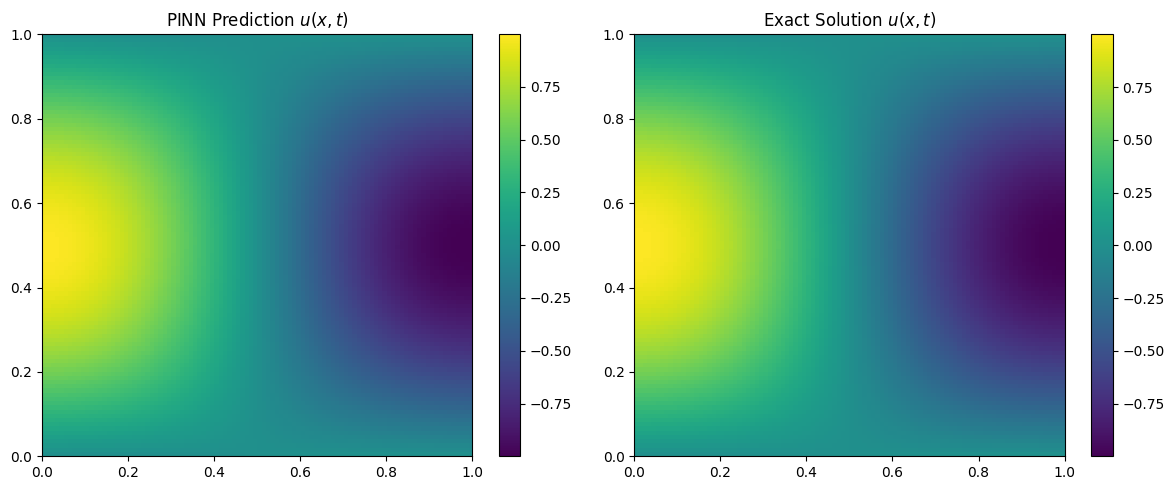

In [6]:
# Evaluation
x_test = torch.linspace(0, 1, 100, device=device).view(-1, 1)
t_test = torch.linspace(0, 1, 100, device=device).view(-1, 1)
X, T = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
xt_test = torch.cat([X.reshape(-1, 1), T.reshape(-1, 1)], dim=1)
u_pred = model(xt_test).detach().cpu().numpy().reshape(100, 100)
u_exact = np.sin(np.pi * X.cpu().numpy()) * np.cos(np.pi * T.cpu().numpy())

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
c0 = axs[0].imshow(u_pred, extent=[0, 1, 0, 1], origin='lower', aspect='auto')
axs[0].set_title('PINN Prediction $u(x,t)$')
fig.colorbar(c0, ax=axs[0])

c1 = axs[1].imshow(u_exact, extent=[0, 1, 0, 1], origin='lower', aspect='auto')
axs[1].set_title('Exact Solution $u(x,t)$')
fig.colorbar(c1, ax=axs[1])

plt.tight_layout()
plt.show()